In [2]:
import os
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load data

In [4]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [5]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root = dataset_path,transform=image_transforms)
len(dataset)

2300

In [6]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [7]:
num_classes = len(dataset.classes)

In [8]:
num_classes

6

In [9]:
train_size = int(0.75*len(dataset))
test_size = len(dataset) - train_size
train_size,test_size

(1725, 575)

In [10]:
from torch.utils.data import random_split

train_dataset,val_dataset = random_split(dataset,[train_size,test_size])

In [11]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=True)

In [12]:
for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [30]:
labels[7]

tensor(2)

In [14]:
images[0].shape

torch.Size([3, 224, 224])

In [15]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

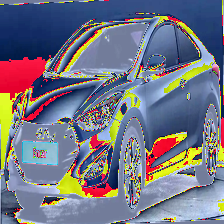

In [31]:
from PIL import Image
from IPython.display import display
import torch

# Take the first image
img = images[7]

# If normalized to [-1,1], unnormalize
img = img / 2 + 0.5

# Convert to numpy
npimg = img.permute(1, 2, 0).cpu().numpy()  # [H,W,C]

# Convert to PIL image
pil_img = Image.fromarray((npimg * 255).astype('uint8'))

# Display inside notebook
display(pil_img)


## Model1:CNN

In [32]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [33]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [34]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.78
Batch: 20, Epoch: 1, Loss: 1.79
Batch: 30, Epoch: 1, Loss: 1.67
Batch: 40, Epoch: 1, Loss: 1.66
Batch: 50, Epoch: 1, Loss: 1.74
Epoch [1/10], Avg Loss: 1.7750
*** Validation Accuracy: 34.96% ***
Batch: 10, Epoch: 2, Loss: 1.41
Batch: 20, Epoch: 2, Loss: 1.34
Batch: 30, Epoch: 2, Loss: 1.56
Batch: 40, Epoch: 2, Loss: 1.46
Batch: 50, Epoch: 2, Loss: 1.29
Epoch [2/10], Avg Loss: 1.3950
*** Validation Accuracy: 45.22% ***
Batch: 10, Epoch: 3, Loss: 1.14
Batch: 20, Epoch: 3, Loss: 1.12
Batch: 30, Epoch: 3, Loss: 1.11
Batch: 40, Epoch: 3, Loss: 0.87
Batch: 50, Epoch: 3, Loss: 0.98
Epoch [3/10], Avg Loss: 1.1828
*** Validation Accuracy: 52.35% ***
Batch: 10, Epoch: 4, Loss: 1.26
Batch: 20, Epoch: 4, Loss: 1.05
Batch: 30, Epoch: 4, Loss: 1.11
Batch: 40, Epoch: 4, Loss: 0.89
Batch: 50, Epoch: 4, Loss: 1.00
Epoch [4/10], Avg Loss: 1.0146
*** Validation Accuracy: 51.48% ***
Batch: 10, Epoch: 5, Loss: 0.89
Batch: 20, Epoch: 5, Loss: 0.88
Batch: 30, Epoch: 5, Loss: 0

## Model 2: CNN wwith Regularization

In [35]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [36]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=5)

Batch: 10, Epoch: 1, Loss: 20.02
Batch: 20, Epoch: 1, Loss: 5.81
Batch: 30, Epoch: 1, Loss: 2.12
Batch: 40, Epoch: 1, Loss: 1.39
Batch: 50, Epoch: 1, Loss: 1.45
Epoch [1/5], Avg Loss: 7.7842
*** Validation Accuracy: 40.35% ***
Batch: 10, Epoch: 2, Loss: 1.42
Batch: 20, Epoch: 2, Loss: 1.28
Batch: 30, Epoch: 2, Loss: 1.59
Batch: 40, Epoch: 2, Loss: 1.31
Batch: 50, Epoch: 2, Loss: 1.58
Epoch [2/5], Avg Loss: 1.4096
*** Validation Accuracy: 45.74% ***
Batch: 10, Epoch: 3, Loss: 1.21
Batch: 20, Epoch: 3, Loss: 1.22
Batch: 30, Epoch: 3, Loss: 1.15
Batch: 40, Epoch: 3, Loss: 1.28
Batch: 50, Epoch: 3, Loss: 1.05
Epoch [3/5], Avg Loss: 1.2729
*** Validation Accuracy: 49.39% ***
Batch: 10, Epoch: 4, Loss: 1.65
Batch: 20, Epoch: 4, Loss: 1.38
Batch: 30, Epoch: 4, Loss: 1.30
Batch: 40, Epoch: 4, Loss: 1.66
Batch: 50, Epoch: 4, Loss: 1.32
Epoch [4/5], Avg Loss: 1.2400
*** Validation Accuracy: 47.13% ***
Batch: 10, Epoch: 5, Loss: 1.07
Batch: 20, Epoch: 5, Loss: 0.87
Batch: 30, Epoch: 5, Loss: 1.12

## Transfer learning using efficientnet

In [37]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [38]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.64
Batch: 20, Epoch: 1, Loss: 1.55
Batch: 30, Epoch: 1, Loss: 1.40
Batch: 40, Epoch: 1, Loss: 1.30
Batch: 50, Epoch: 1, Loss: 1.28
Epoch [1/10], Avg Loss: 1.4806
*** Validation Accuracy: 58.09% ***
Batch: 10, Epoch: 2, Loss: 1.19
Batch: 20, Epoch: 2, Loss: 1.20
Batch: 30, Epoch: 2, Loss: 1.09
Batch: 40, Epoch: 2, Loss: 1.09
Batch: 50, Epoch: 2, Loss: 0.98
Epoch [2/10], Avg Loss: 1.1261
*** Validation Accuracy: 58.78% ***
Batch: 10, Epoch: 3, Loss: 1.00
Batch: 20, Epoch: 3, Loss: 0.99
Batch: 30, Epoch: 3, Loss: 1.01
Batch: 40, Epoch: 3, Loss: 0.94
Batch: 50, Epoch: 3, Loss: 1.10
Epoch [3/10], Avg Loss: 1.0080
*** Validation Accuracy: 60.70% ***
Batch: 10, Epoch: 4, Loss: 0.78
Batch: 20, Epoch: 4, Loss: 1.00
Batch: 30, Epoch: 4, Loss: 0.79
Batch: 40, Epoch: 4, Loss: 0.76
Batch: 50, Epoch: 4, Loss: 0.91
Epoch [4/10], Avg Loss: 0.9291
*** Validation Accuracy: 65.04% ***
Batch: 10, Epoch: 5, Loss: 0.71
Batch: 20, Epoch: 5, Loss: 0.96
Batch: 30, Epoch: 5, Loss: 0

## Transfer learning with ResNet

In [39]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [40]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\sriwa/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [01:19<00:00, 1.29MB/s]


Batch: 10, Epoch: 1, Loss: 0.82
Batch: 20, Epoch: 1, Loss: 1.06
Batch: 30, Epoch: 1, Loss: 0.67
Batch: 40, Epoch: 1, Loss: 0.80
Batch: 50, Epoch: 1, Loss: 0.79
Epoch [1/10], Avg Loss: 0.8623
*** Validation Accuracy: 66.61% ***
Batch: 10, Epoch: 2, Loss: 0.33
Batch: 20, Epoch: 2, Loss: 0.34
Batch: 30, Epoch: 2, Loss: 0.81
Batch: 40, Epoch: 2, Loss: 0.66
Batch: 50, Epoch: 2, Loss: 0.44
Epoch [2/10], Avg Loss: 0.4756
*** Validation Accuracy: 78.61% ***
Batch: 10, Epoch: 3, Loss: 0.29
Batch: 20, Epoch: 3, Loss: 0.37
Batch: 30, Epoch: 3, Loss: 0.38
Batch: 40, Epoch: 3, Loss: 0.39
Batch: 50, Epoch: 3, Loss: 0.54
Epoch [3/10], Avg Loss: 0.3651
*** Validation Accuracy: 75.65% ***
Batch: 10, Epoch: 4, Loss: 0.14
Batch: 20, Epoch: 4, Loss: 0.09
Batch: 30, Epoch: 4, Loss: 0.28
Batch: 40, Epoch: 4, Loss: 0.15
Batch: 50, Epoch: 4, Loss: 0.25
Epoch [4/10], Avg Loss: 0.2369
*** Validation Accuracy: 74.43% ***
Batch: 10, Epoch: 5, Loss: 0.07
Batch: 20, Epoch: 5, Loss: 0.43
Batch: 30, Epoch: 5, Loss: 0

#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

So now let's train the model once again with these best parameters

In [41]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.36
Batch: 20, Epoch: 1, Loss: 0.82
Batch: 30, Epoch: 1, Loss: 0.94
Batch: 40, Epoch: 1, Loss: 0.61
Batch: 50, Epoch: 1, Loss: 0.60
Epoch [1/10], Avg Loss: 0.8578
*** Validation Accuracy: 66.78% ***
Batch: 10, Epoch: 2, Loss: 0.54
Batch: 20, Epoch: 2, Loss: 0.30
Batch: 30, Epoch: 2, Loss: 0.34
Batch: 40, Epoch: 2, Loss: 0.28
Batch: 50, Epoch: 2, Loss: 0.76
Epoch [2/10], Avg Loss: 0.4989
*** Validation Accuracy: 77.04% ***
Batch: 10, Epoch: 3, Loss: 0.46
Batch: 20, Epoch: 3, Loss: 0.31
Batch: 30, Epoch: 3, Loss: 0.45
Batch: 40, Epoch: 3, Loss: 0.41
Batch: 50, Epoch: 3, Loss: 0.42
Epoch [3/10], Avg Loss: 0.4111
*** Validation Accuracy: 72.00% ***
Batch: 10, Epoch: 4, Loss: 0.26
Batch: 20, Epoch: 4, Loss: 0.30
Batch: 30, Epoch: 4, Loss: 0.32
Batch: 40, Epoch: 4, Loss: 0.31
Batch: 50, Epoch: 4, Loss: 0.17
Epoch [4/10], Avg Loss: 0.3132
*** Validation Accuracy: 76.70% ***
Batch: 10, Epoch: 5, Loss: 0.16
Batch: 20, Epoch: 5, Loss: 0.15
Batch: 30, Epoch: 5, Loss: 0

## Model Evaluation using Confusion Matrix and Classification Report

In [42]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       121
           1       0.81      0.77      0.79        96
           2       0.89      0.87      0.88       135
           3       0.80      0.75      0.77        80
           4       0.70      0.75      0.72        73
           5       0.73      0.80      0.76        70

    accuracy                           0.81       575
   macro avg       0.79      0.80      0.79       575
weighted avg       0.81      0.81      0.81       575



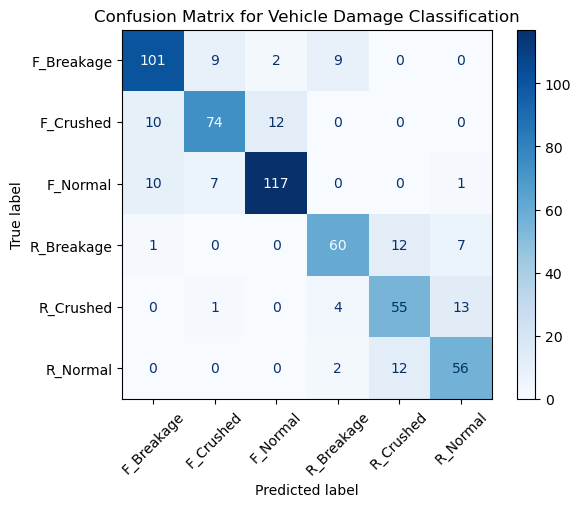

In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

## model exporting

In [45]:
torch.save(model.state_dict(), 'saved_model.pth')

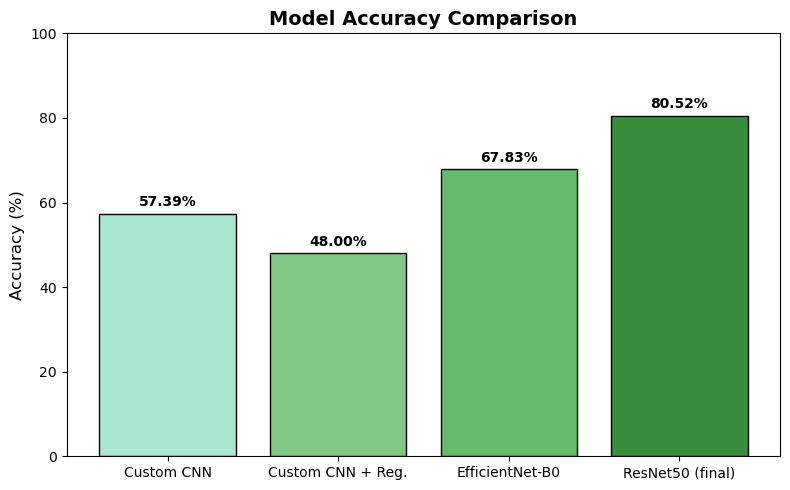

In [1]:
import matplotlib.pyplot as plt

# Data
models = ['Custom CNN', 'Custom CNN + Reg.', 'EfficientNet-B0', 'ResNet50 (final)']
accuracies = [57.39, 48.00, 67.83, 80.52]

# Greenish color palette
colors = ['#a8e6cf', '#81c784', '#66bb6a', '#388e3c']

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=colors, edgecolor='black')

# Add labels and title
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 100)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Improve layout
plt.tight_layout()
plt.show()


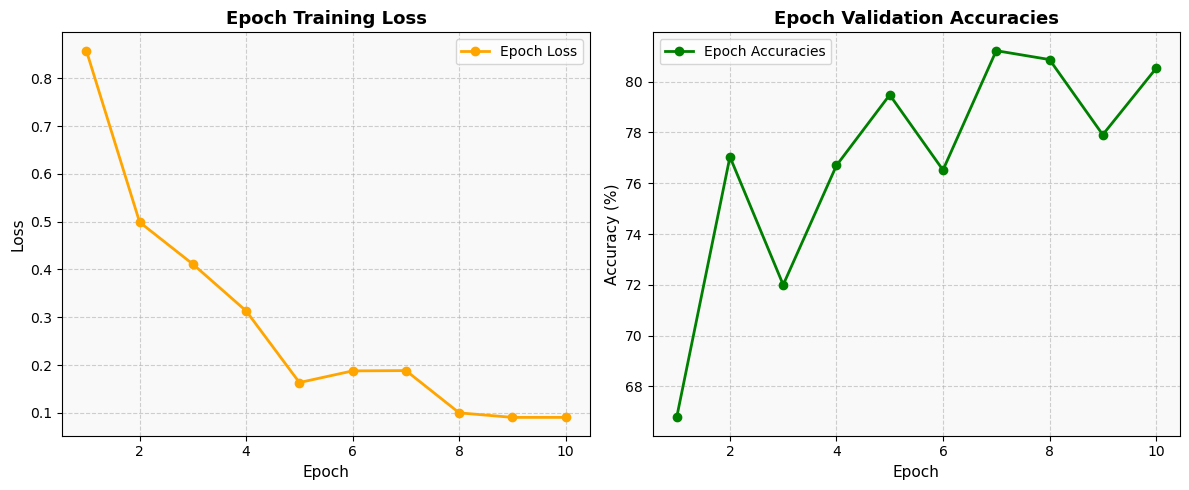

In [2]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 11))
avg_loss = [0.8578, 0.4989, 0.4111, 0.3132, 0.1634, 0.1878, 0.1884, 0.1000, 0.0905, 0.0905]
val_acc = [66.78, 77.04, 72.00, 76.70, 79.48, 76.52, 81.22, 80.87, 77.91, 80.52]

# Create figure with two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Left plot: Training Loss ---
ax1.plot(epochs, avg_loss, color='orange', marker='o', label='Epoch Loss', linewidth=2)
ax1.set_title('Epoch Training Loss', fontsize=13, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()
ax1.set_facecolor('#f9f9f9')

# --- Right plot: Validation Accuracy ---
ax2.plot(epochs, val_acc, color='green', marker='o', label='Epoch Accuracies', linewidth=2)
ax2.set_title('Epoch Validation Accuracies', fontsize=13, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy (%)', fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()
ax2.set_facecolor('#f9f9f9')

# Global styling
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()
